### `imports`

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

### `load data`

In [2]:
# Load the dataset
train_df = pd.read_csv(os.path.join(os.getcwd(), "data", "train.csv"))   # Kaggle training data

In [3]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


### `Quick EDA`

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [5]:
train_df.drop(columns=['id'], inplace=True)

In [6]:
train_df.isna().sum().sum()

np.int64(0)

In [7]:
train_df.duplicated().sum()

np.int64(2841)

In [8]:
train_df.shape

(750000, 8)

In [9]:
train_df.drop_duplicates(inplace=True)

In [10]:
train_df.shape

(747159, 8)

In [11]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,747159.0,41.419769,15.183108,20.0,28.0,40.0,52.0,79.0
Height,747159.0,174.694787,12.820127,126.0,164.0,174.0,185.0,222.0
Weight,747159.0,75.140631,13.976613,36.0,63.0,74.0,87.0,132.0
Duration,747159.0,15.433359,8.352766,1.0,8.0,15.0,23.0,30.0
Heart_Rate,747159.0,95.495497,9.451046,67.0,88.0,95.0,103.0,128.0
Body_Temp,747159.0,40.037302,0.779242,37.1,39.6,40.3,40.7,41.5
Calories,747159.0,88.364584,62.398057,1.0,34.0,77.0,136.0,314.0


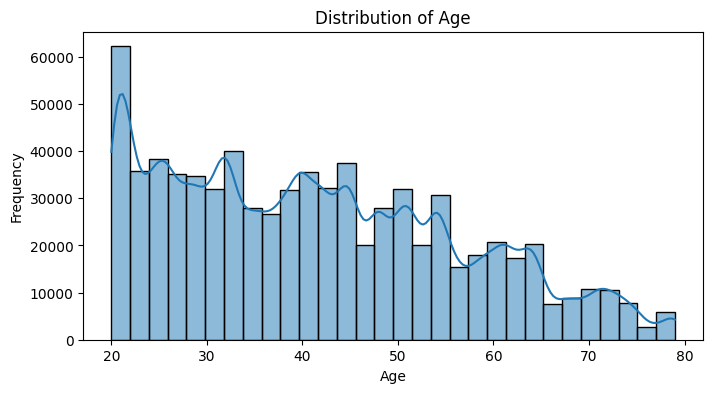

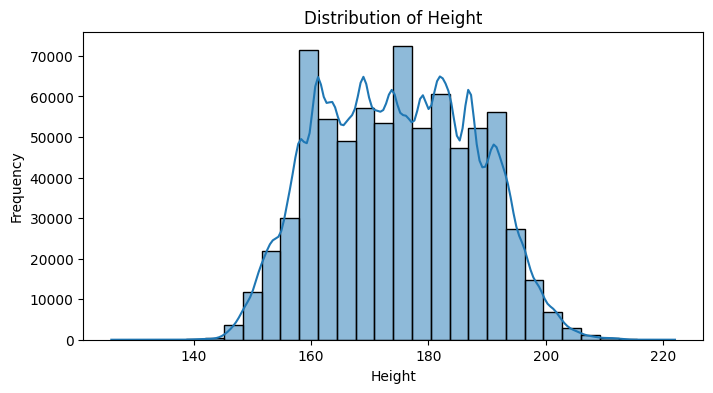

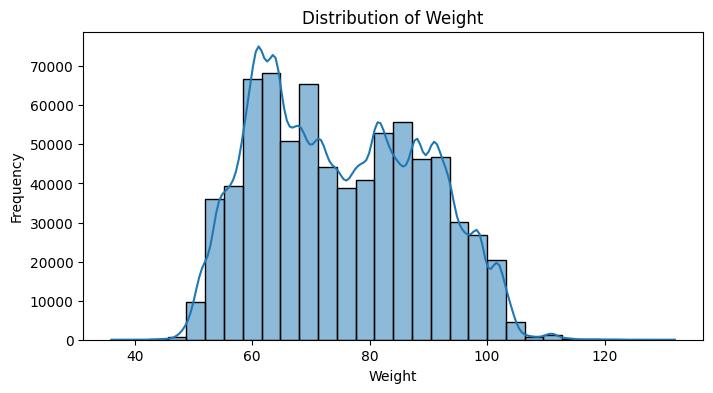

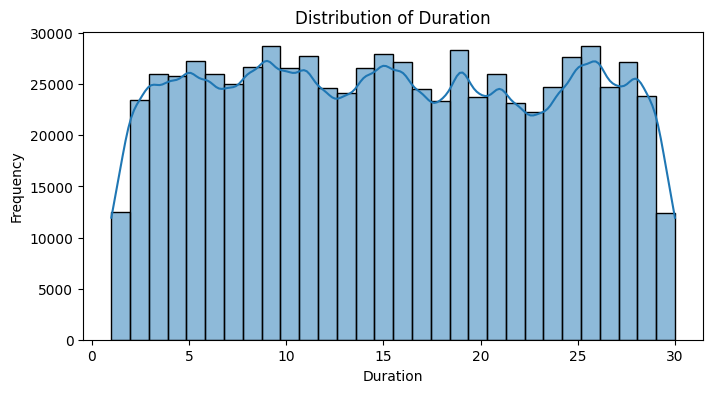

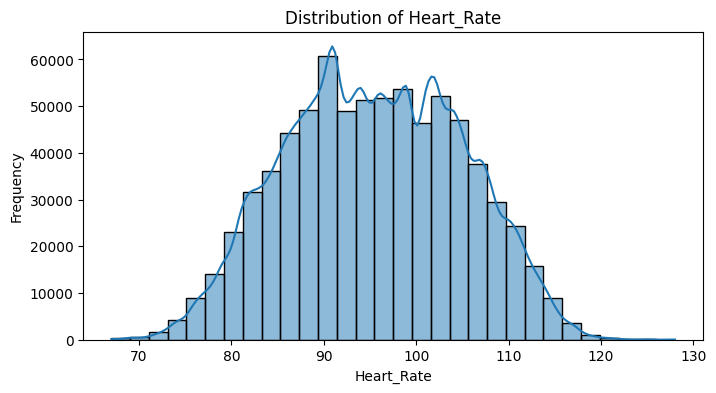

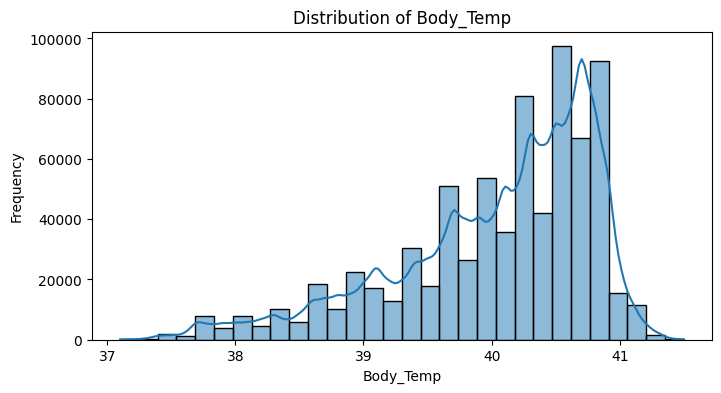

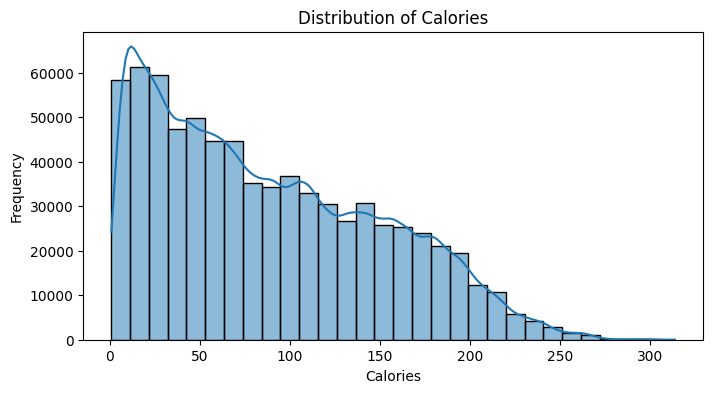

In [12]:
# features distribution

# List of features to visualize (numerical)
num_features = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Plot distribution for each numerical feature
for feature in num_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

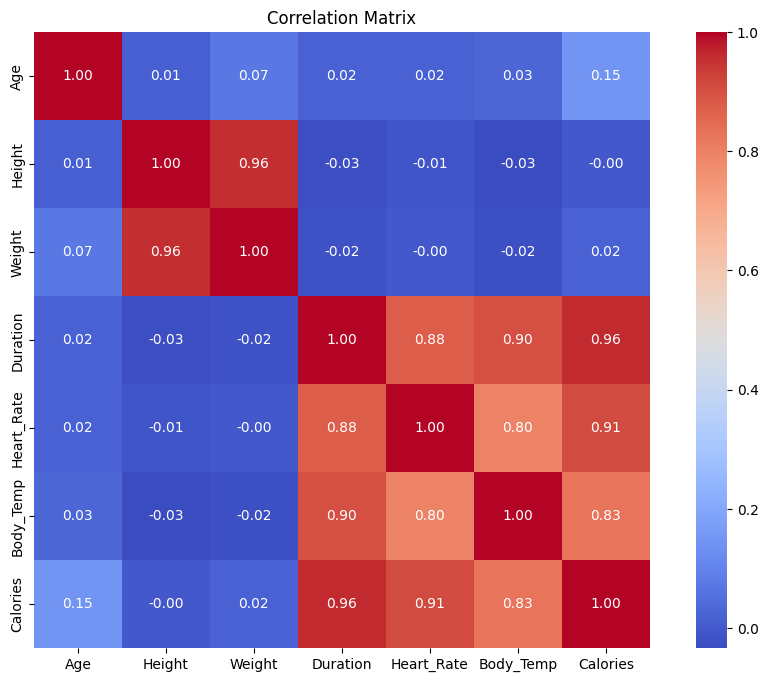

In [17]:
# correlation matrix
corr = train_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [13]:
# check for outliers
def detect_outliers_zscore(df, columns, threshold=2.2):
    outlier_counts = {}
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_counts[col] = (z_scores > threshold).sum()
    return outlier_counts

def remove_outliers_zscore(df, columns, threshold=2):
    outlier_mask = pd.Series(False, index=df.index)  # initialize mask
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_mask |= (z_scores > threshold)  # mark outliers
    df_clean = df.loc[~outlier_mask].reset_index(drop=True)
    return df_clean, outlier_mask.sum()

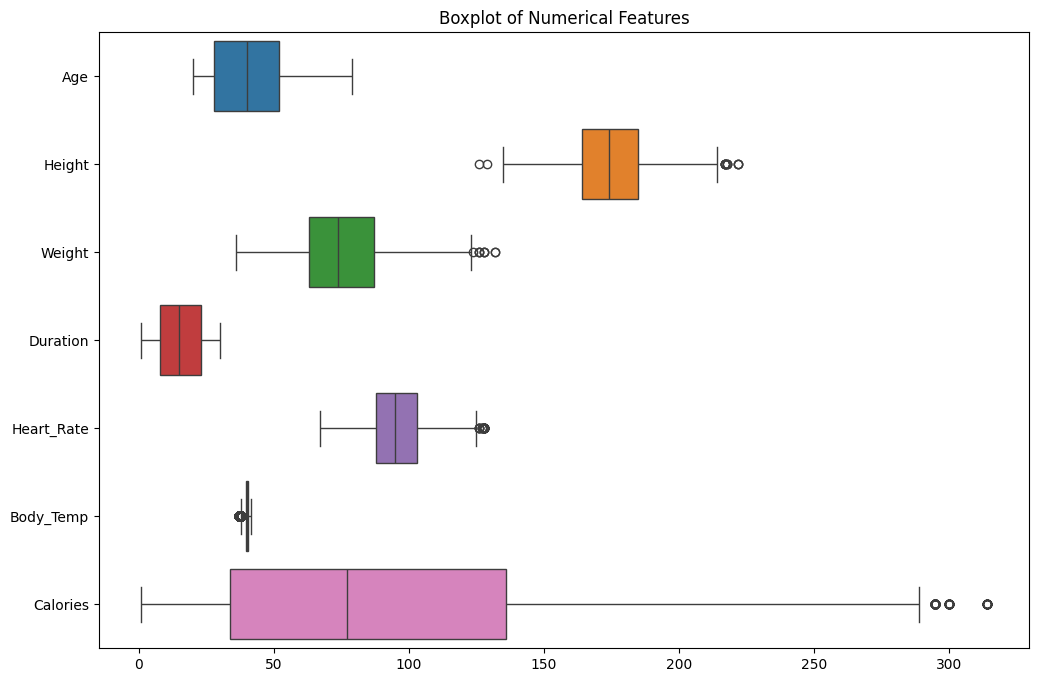

In [18]:
# boxplot for numerical features
num_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df[num_features], orient="h")
plt.title('Boxplot of Numerical Features')
plt.show()

In [14]:
# Columns to check
cols_to_check = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Just detect (don’t overwrite train_df)
outlier_counts = detect_outliers_zscore(train_df, cols_to_check)
print("Z-score outliers per column:", outlier_counts)

Z-score outliers per column: {'Age': np.int64(12699), 'Height': np.int64(5717), 'Weight': np.int64(2877), 'Duration': np.int64(0), 'Heart_Rate': np.int64(7945), 'Body_Temp': np.int64(32977), 'Calories': np.int64(12810)}


In [ ]:
def remove_outliers_zscore(df, columns, threshold=2):
    outlier_mask = pd.Series(False, index=df.index)  # initialize mask
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_mask |= (z_scores > threshold)  # mark outliers
    df_clean = df.loc[~outlier_mask].reset_index(drop=True)
    return df_clean, outlier_mask.sum()


# Remove
train_df, removed_count = remove_outliers_zscore(train_df, cols_to_check, threshold=2)
print(f"Removed {removed_count} outliers. Train set shape: {train_df.shape}")

`Feature Engineering`

In [ ]:
'''
train_df['BMI'] = train_df['Weight'] / ((train_df['Height']/100) ** 2)
train_df['Workload'] = train_df['Weight'] * train_df['Duration']
train_df['Cardio_Load'] = train_df['Heart_Rate'] * train_df['Duration']
train_df['Temp_Stress'] = (train_df['Body_Temp'] - 37) * train_df['Duration']
train_df['HR_Ratio'] = train_df['Heart_Rate'] / (220 - train_df['Age'])
train_df['Wt_per_Height'] = train_df['Weight'] / train_df['Height']
'''

In [ ]:
#train_df['Body_Temp'] = np.sqrt(train_df['Body_Temp'])

In [ ]:
'''# Workload and cardio load indices
train_df['Workload'] = train_df['Weight'] * train_df['Duration']
train_df['Cardio_Load'] = train_df['Heart_Rate'] * train_df['Duration']
train_df['Metabolic_Index'] = train_df['Body_Temp'] * train_df['Heart_Rate']'''

In [ ]:
# log1p transform slightly skewed feature
#train_df['Body_Temp'] = np.log1p(train_df['Body_Temp'])

In [ ]:
'''

# Squared features
train_df['Duration_Sq'] = train_df['Duration'] ** 2
train_df['Heart_Rate_Sq'] = train_df['Heart_Rate'] ** 2
train_df['Weight_Sq'] = train_df['Weight'] ** 2
# cubed features
train_df['Duration_Cub'] = train_df['Duration'] ** 3
train_df['Heart_Rate_Cub'] = train_df['Heart_Rate'] ** 3
train_df['Weight_Cub'] = train_df['Weight'] ** 3

# Inverse duration
train_df['Inv_Duration'] = 1 / train_df['Duration']
train_df['Inv_Heart_Rate'] = 1 / train_df['Heart_Rate']
train_df['Inv_Weight'] = 1 / train_df['Weight']
train_df['Inv_Body_Temp'] = 1 / train_df['Body_Temp']

# sqrt
train_df['Sqrt_Body_Temp'] = train_df['Body_Temp'] ** 0.5

'''


`FINAL FUNCTION`

In [13]:
def feature_extraction(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Derived features
    df['Workload'] = df['Weight'] * df['Duration']
    df['Cardio_Load'] = df['Heart_Rate'] * df['Duration']
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    df['Temp_Stress'] = (df['Body_Temp'] - 37) * df['Duration']
    df['HR_Ratio'] = df['Heart_Rate'] / (220 - df['Age'])
    df['Wt_per_Height'] = df['Weight'] / df['Height']
    df['Sqrt_Body_Temp'] = np.sqrt(df['Body_Temp'])

    return df


'''
    # Squared
    df['Duration_Sq'] = df['Duration'] ** 2
    df['Heart_Rate_Sq'] = df['Heart_Rate'] ** 2
    df['Weight_Sq'] = df['Weight'] ** 2
    df['Body_Temp_Sq'] = df['Body_Temp'] ** 2

    # Cubed
    df['Duration_Cub'] = df['Duration'] ** 3
    df['Heart_Rate_Cub'] = df['Heart_Rate'] ** 3
    df['Weight_Cub'] = df['Weight'] ** 3
    df['Body_Temp_Cub'] = df['Body_Temp'] ** 3

    # Inverse
    df['Inv_Duration'] = 1 / df['Duration']
    df['Inv_Heart_Rate'] = 1 / df['Heart_Rate']
    df['Inv_Weight'] = 1 / df['Weight']
    df['Inv_Body_Temp'] = 1 / df['Body_Temp']

    # Square root
    df['Sqrt_Body_Temp'] = np.sqrt(df['Body_Temp'])
'''

"\n    # Squared\n    df['Duration_Sq'] = df['Duration'] ** 2\n    df['Heart_Rate_Sq'] = df['Heart_Rate'] ** 2\n    df['Weight_Sq'] = df['Weight'] ** 2\n    df['Body_Temp_Sq'] = df['Body_Temp'] ** 2\n\n    # Cubed\n    df['Duration_Cub'] = df['Duration'] ** 3\n    df['Heart_Rate_Cub'] = df['Heart_Rate'] ** 3\n    df['Weight_Cub'] = df['Weight'] ** 3\n    df['Body_Temp_Cub'] = df['Body_Temp'] ** 3\n\n    # Inverse\n    df['Inv_Duration'] = 1 / df['Duration']\n    df['Inv_Heart_Rate'] = 1 / df['Heart_Rate']\n    df['Inv_Weight'] = 1 / df['Weight']\n    df['Inv_Body_Temp'] = 1 / df['Body_Temp']\n\n    # Square root\n    df['Sqrt_Body_Temp'] = np.sqrt(df['Body_Temp'])\n"

`prepare data`

In [14]:
train_df = feature_extraction(train_df)

In [15]:
train_df.shape

(747159, 15)

In [16]:
X = train_df.drop('Calories', axis=1)
y = train_df['Calories']

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# preprocessing pipeline
# standardization for numerical and ohe for categorical(sex)

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)

In [21]:
len(X_train_processed)

597727

In [22]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=2000, learning_rate=0.03,
    num_leaves=128, subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

y_pred_lgb = lgb_model.predict(X_val_processed)
rmse_lgb = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
print(f'Validation RMSE: {rmse_lgb:.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 597727, number of used features: 14
[LightGBM] [Info] Start training from score 88.383506
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 4.88342	valid_0's l2: 23.8478
[200]	valid_0's rmse: 3.60123	valid_0's l2: 12.9689
[300]	valid_0's rmse: 3.57393	valid_0's l2: 12.773
[400]	valid_0's rmse: 3.57098	valid_0's l2: 12.7519
[500]	valid_0's rmse: 3.56913	valid_0's l2: 12.7387
[600]	valid_0's rmse: 3.56885	valid_0's l2: 12.7367
Early stopping, best iteration is:
[536]	valid_0's rmse: 3.56853	valid_0's l2: 12.7344


c:\Users\laphouse\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Validation RMSE: 3.569


`train on most of data (full pipeline)`

- without preprocessing

In [23]:
# --- Load and clean data ---
train_path = os.path.join(os.getcwd(), "data", "train.csv")
train_df = pd.read_csv(train_path)

# Drop unused columns and duplicates
train_df = train_df.drop(columns=['id'])  # .drop_duplicates()
train_df['Sex'] = (train_df['Sex'] == 'male').astype(int)


# Remove outliers
# cols_to_check = train_df.select_dtypes(include=[np.number]).columns.tolist()
# train_df, removed_count = remove_outliers_zscore(
#     df=train_df,
#     columns=cols_to_check,
#     threshold=2
# )
# print(f"Removed {removed_count} outliers. Train set shape: {train_df.shape}")

# Feature engineering
train_df = feature_extraction(train_df)

# Split features/target
X = train_df.drop('Calories', axis=1)
y = train_df['Calories']

# --- Split into train/validation (8% val) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.08, random_state=42
)

# Preprocess
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#X_train = preprocessing_pipeline.fit_transform(X_train)
#X_val = preprocessing_pipeline.transform(X_val)

# --- Train LightGBM model ---
lgb_model_f = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model_f.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1914
[LightGBM] [Info] Number of data points in the train set: 690000, number of used features: 14
[LightGBM] [Info] Start training from score 88.306639
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.7328	valid_0's l2: 13.9338
[200]	valid_0's rmse: 3.66187	valid_0's l2: 13.4093
[300]	valid_0's rmse: 3.65489	valid_0's l2: 13.3582
[400]	valid_0's rmse: 3.65323	valid_0's l2: 13.3461
[500]	valid_0's rmse: 3.6543	valid_0's l2: 13.3539
Early stopping, best iteration is:
[444]	valid_0's rmse: 3.65164	valid_0's l2: 13.3345


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=2000,
              num_leaves=128, random_state=42, subsample=0.8)

`submussion`

In [24]:
# --- Prepare test data ---
test_path = os.path.join(os.getcwd(), "data", "test.csv")
test_df = pd.read_csv(test_path)

# Keep ID column for submission
test_ids = test_df['id'].copy()

# Apply feature engineering (same as train)
test_df = feature_extraction(test_df.drop(columns=['id']))
test_df['Sex'] = (test_df['Sex'] == 'male').astype(int)


test_df = test_df[X.columns]  # X from training phase before preprocessing

# Preprocess using pipeline fitted on training data
# X_test_processed = preprocessing_pipeline.transform(test_df)

# Predict using best iteration from early stopping
y_test_pred = lgb_model_f.predict(test_df)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'Calories': y_test_pred
})

# Save submission
submission_path = os.path.join(os.getcwd(), "output", "submission.csv")
submission.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")

Submission saved to c:\Users\laphouse\Projects\MIA\MIA_phase1\Block3\task3.2\output\submission.csv


`train XGBOOST`

In [26]:
# Read data
train_path = os.path.join(os.getcwd(), "data", "train.csv")
train_df = pd.read_csv(train_path)

# Drop unused columns and duplicates
train_df = train_df.drop(columns=['id'])  # .drop_duplicates()
train_df['Sex'] = (train_df['Sex'] == 'male').astype(int)

# Feature engineering
train_df = feature_extraction(train_df)

# Split features/target
X = train_df.drop('Calories', axis=1)
y = train_df['Calories']

# --- Split into train/validation (8% val) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.08, random_state=42
)

# Preprocess
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform features, it generalizes better without standardization
#X_train = preprocessing_pipeline.fit_transform(X_train)
#X_val = preprocessing_pipeline.transform(X_val)

# --- Train XGBoost model ---
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,            # similar control to num_leaves
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",     # faster, recommended for modern versions
    eval_metric='rmse'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-rmse:59.24978
[100]	validation_0-rmse:3.70870
[200]	validation_0-rmse:3.65966
[300]	validation_0-rmse:3.65520
[400]	validation_0-rmse:3.65270
[500]	validation_0-rmse:3.65187
[600]	validation_0-rmse:3.65207
[700]	validation_0-rmse:3.65254
[800]	validation_0-rmse:3.65295
[900]	validation_0-rmse:3.65228
[1000]	validation_0-rmse:3.65369
[1100]	validation_0-rmse:3.65508
[1200]	validation_0-rmse:3.65695
[1300]	validation_0-rmse:3.65841
[1400]	validation_0-rmse:3.65927
[1500]	validation_0-rmse:3.66139
[1600]	validation_0-rmse:3.66290
[1700]	validation_0-rmse:3.66540
[1800]	validation_0-rmse:3.66791
[1900]	validation_0-rmse:3.67037
[1999]	validation_0-rmse:3.67371


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

`ensemble trial`

In [27]:
lgb_pred = lgb_model_f.predict(X_val)
xgb_pred = xgb_model.predict(X_val)

In [28]:
# average ensemble 
pred_ensemble = (lgb_pred + xgb_pred ) / 2

rmse_ensemble = np.sqrt(mean_squared_error(y_val, pred_ensemble))
print(f'Validation RMSE (Ensemble): {rmse_ensemble:.4f}')

Validation RMSE (Ensemble): 3.6328


`ensemble submission`

In [29]:
# --- Prepare test data ---
test_path = os.path.join(os.getcwd(), "data", "test.csv")
test_df = pd.read_csv(test_path)

# Keep ID column for submission
test_ids = test_df['id'].copy()

# Apply feature engineering (same as train)
test_df = feature_extraction(test_df.drop(columns=['id']))
test_df['Sex'] = (test_df['Sex'] == 'male').astype(int)


test_df = test_df[X.columns]  # X from training phase before preprocessing

# Preprocess using pipeline fitted on training data
# X_test_processed = preprocessing_pipeline.transform(test_df)

# Predict calories with each model
y_test_pred_lgb = lgb_model.predict(test_df)
y_test_pred_xgb = xgb_model.predict(test_df)

# Ensemble prediction (simple average)
y_test_pred = (y_test_pred_lgb + y_test_pred_xgb) / 2

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'Calories': y_test_pred
})

# Save submission
submission_path = os.path.join(os.getcwd(), "output", "submission_ensemble.csv")
submission.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")

Submission saved to c:\Users\laphouse\Projects\MIA\MIA_phase1\Block3\task3.2\output\submission_ensemble.csv
